# Estimating prediction intervals of time series forecast with EnbPI

This example uses :class:`mapie.time_series_regression.MapieTimeSeriesRegressor` to estimate
prediction intervals associated with time series forecast. It follows [6] and
an alternative expermimental implemetation inspired from [2]

We use here the Victoria electricity demand dataset used in the book
"Forecasting: Principles and Practice" by R. J. Hyndman and G. Athanasopoulos.
The electricity demand features daily and weekly seasonalities and is impacted
by the temperature, considered here as a exogeneous variable.

A Random Forest model is already fitted on data. The hyper-parameters are
optimized with a :class:`sklearn.model_selection.RandomizedSearchCV` using a
sequential :class:`sklearn.model_selection.TimeSeriesSplit` cross validation,
in which the training set is prior to the validation set.
The best model is then feeded into
:class:`mapie.time_series_regression.MapieTimeSeriesRegressor` to estimate the
associated prediction intervals. We compare four approaches: with or without
``partial_fit`` called at every step, and following [6] or a approach inspired
from [2]. It appears that the approach inspired from [2] and ``partial_fit``
offer higher coverage, but with higher width of PIs and are much slower.

In [1]:
import warnings

import numpy as np
import pandas as pd
from matplotlib import pylab as plt
from scipy.stats import randint
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit

from mapie.metrics import regression_coverage_score, regression_mean_width_score
from mapie.subsample import BlockBootstrap
from mapie.time_series_regression import MapieTimeSeriesRegressor

warnings.simplefilter("ignore")

## 1. Load input data and feature engineering

In [2]:
url_file = "https://raw.githubusercontent.com/scikit-learn-contrib/MAPIE/master/examples/data/demand_temperature.csv"
demand_df = pd.read_csv(
    url_file, parse_dates=True, index_col=0
)

demand_df["Date"] = pd.to_datetime(demand_df.index)
demand_df["Weekofyear"] = demand_df.Date.dt.isocalendar().week.astype("int64")
demand_df["Weekday"] = demand_df.Date.dt.isocalendar().day.astype("int64")
demand_df["Hour"] = demand_df.index.hour
n_lags = 5
for hour in range(1, n_lags):
    demand_df[f"Lag_{hour}"] = demand_df["Demand"].shift(hour)


## 2. Train/validation/test split

In [3]:
num_test_steps = 24 * 7
demand_train = demand_df.iloc[:-num_test_steps, :].copy()
demand_test = demand_df.iloc[-num_test_steps:, :].copy()
features = ["Weekofyear", "Weekday", "Hour", "Temperature"] 
features += [f"Lag_{hour}" for hour in range(1, n_lags)]

X_train = demand_train.loc[
    ~np.any(demand_train[features].isnull(), axis=1), features
]
y_train = demand_train.loc[X_train.index, "Demand"]
X_test = demand_test.loc[:, features]
y_test = demand_test["Demand"]

## 3. Optimize the base estimator

In [4]:
model_params_fit_not_done = False
if model_params_fit_not_done:
    # CV parameter search
    n_iter = 100
    n_splits = 5
    tscv = TimeSeriesSplit(n_splits=n_splits)
    random_state = 59
    rf_model = RandomForestRegressor(random_state=random_state)
    rf_params = {"max_depth": randint(2, 30), "n_estimators": randint(10, 100)}
    cv_obj = RandomizedSearchCV(
        rf_model,
        param_distributions=rf_params,
        n_iter=n_iter,
        cv=tscv,
        scoring="neg_root_mean_squared_error",
        random_state=random_state,
        verbose=0,
        n_jobs=-1,
    )
    cv_obj.fit(X_train, y_train)
    model = cv_obj.best_estimator_
else:
    # Model: Random Forest previously optimized with a cross-validation
    model = RandomForestRegressor(
        max_depth=10, n_estimators=50, random_state=59)

## 4. Estimate prediction intervals on the test set

In [5]:
alpha = 0.05
gap = 1
cv_mapiets = BlockBootstrap(
    n_resamplings=100, length=48, overlapping=True, random_state=59
)
mapie_enpbi = MapieTimeSeriesRegressor(
    model, method="enbpi", cv=cv_mapiets, agg_function="mean", n_jobs=-1
)

### Without partial fit

In [6]:
print("EnbPI, with no partial_fit, width optimization")
mapie_enpbi = mapie_enpbi.fit(X_train, y_train)
y_pred_npfit, y_pis_npfit = mapie_enpbi.predict(
    X_test, alpha=alpha, ensemble=True, beta_optimize=True
)
coverage_npfit = regression_coverage_score(
    y_test, y_pis_npfit[:, 0, 0], y_pis_npfit[:, 1, 0]
)
width_npfit = regression_mean_width_score(
    y_pis_npfit[:, 0, 0], y_pis_npfit[:, 1, 0]
)

EnbPI, with no partial_fit, width optimization
(168, 2, 1)


### With partial fit

In [7]:
print("EnbPI with partial_fit, width optimization")
mapie_enpbi = mapie_enpbi.fit(X_train, y_train)

y_pred_pfit = np.zeros(y_pred_npfit.shape)
y_pis_pfit = np.zeros(y_pis_npfit.shape)
y_pred_pfit[:gap], y_pis_pfit[:gap, :, :] = mapie_enpbi.predict(
    X_test.iloc[:gap, :], alpha=alpha, ensemble=True
)
for step in range(gap, len(X_test), gap):
    mapie_enpbi.partial_fit(
        X_test.iloc[(step - gap):step, :],
        y_test.iloc[(step - gap):step],
    )
    (
        y_pred_pfit[step:step + gap],
        y_pis_pfit[step:step + gap, :, :],
    ) = mapie_enpbi.predict(
        X_test.iloc[step:(step + gap), :],
        alpha=alpha,
        ensemble=True
    )
coverage_pfit = regression_coverage_score(
    y_test, y_pis_pfit[:, 0, 0], y_pis_pfit[:, 1, 0]
)
width_pfit = regression_mean_width_score(
    y_pis_pfit[:, 0, 0], y_pis_pfit[:, 1, 0]
)

EnbPI with partial_fit, width optimization


KeyboardInterrupt: 

In [ ]:
print(
    "Coverage / prediction interval width mean for MapieTimeSeriesRegressor: "
    "\nEnbPI without any partial_fit:"
    f"{coverage_npfit :.3f}, {width_npfit:.3f}"
)
print(
    "Coverage / prediction interval width mean for MapieTimeSeriesRegressor: "
    "\nEnbPI with partial_fit:"
    f"{coverage_pfit:.3f}, {width_pfit:.3f}"
)

Coverage / prediction interval width mean for MapieTimeSeriesRegressor: 
EnbPI without any partial_fit:0.917, 0.302
Coverage / prediction interval width mean for MapieTimeSeriesRegressor: 
EnbPI with partial_fit:0.905, 0.298


# Plot estimated prediction intervals on test set

In [ ]:
y_preds = [y_pred_npfit, y_pred_pfit]
y_pis = [y_pis_npfit, y_pis_pfit]
coverages = [coverage_npfit, coverage_pfit]
widths = [width_npfit, width_pfit]

In [ ]:
def plot_forecast(y_test, y_preds, y_pis, coverages, widths):
    fig, axs = plt.subplots(
        nrows=2, ncols=1, figsize=(16, 16), sharey="row", sharex="col"
    )
    for i, (ax, w) in enumerate(zip(axs, ["without", "with"])):
        ax.set_ylabel("Hourly demand (GW)")
        ax.plot(y_test, lw=2, label="Test data", c="C1")

        ax.plot(
            demand_test.index, y_preds[i], lw=2, c="C2", label="Predictions"
        )
        ax.fill_between(
            y_test.index,
            y_pis[i][:, 0, 0],
            y_pis[i][:, 1, 0],
            color="C2",
            alpha=0.2,
            label="MapieTimeSeriesRegressor PIs",
        )
        ax.set_title(
            f"EnbPI, {w} partial_fit.\n"
            f"Coverage:{coverages[i]:.3f}  Width:{widths[i]:.3f}"
        )
        ax.legend()
    plt.show()

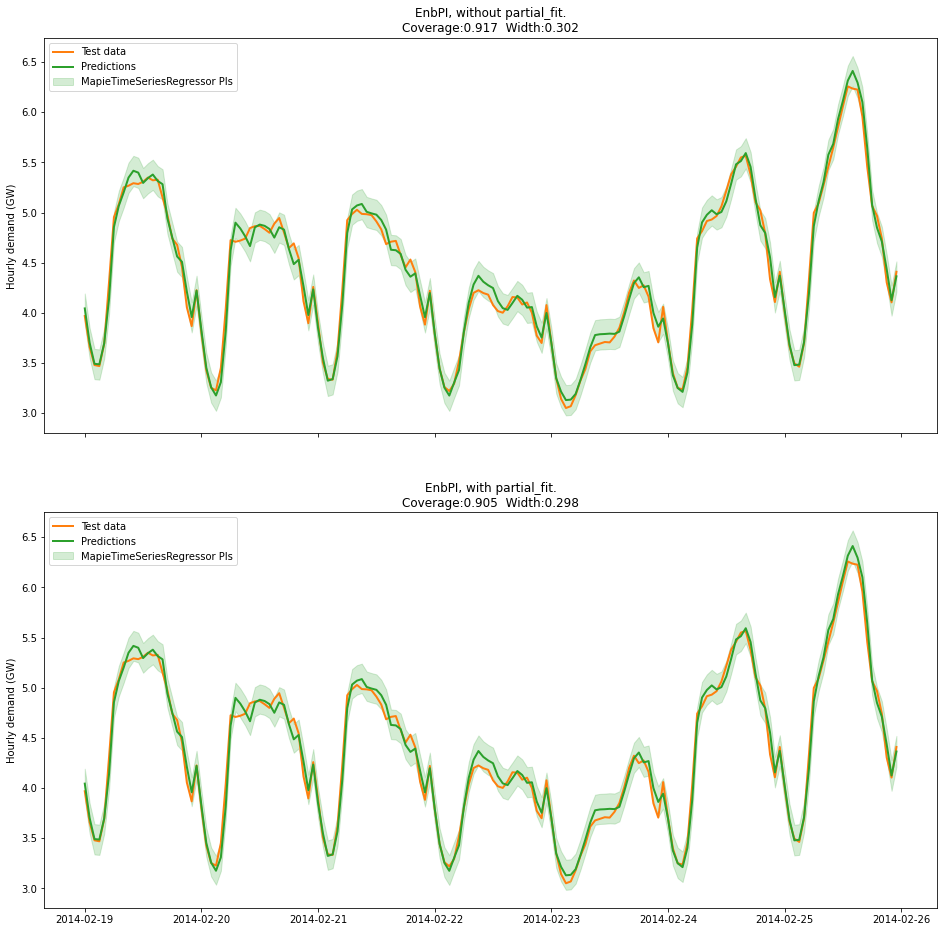

In [ ]:
plot_forecast(y_test, y_preds, y_pis, coverages, widths)